In [1]:
import nltk
import os
import re
import math
import pandas as pd
import numpy as np
import copy
import string
import random
import itertools
import time
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
%matplotlib notebook

Time to pre-process19.375


<IPython.core.display.Javascript object>


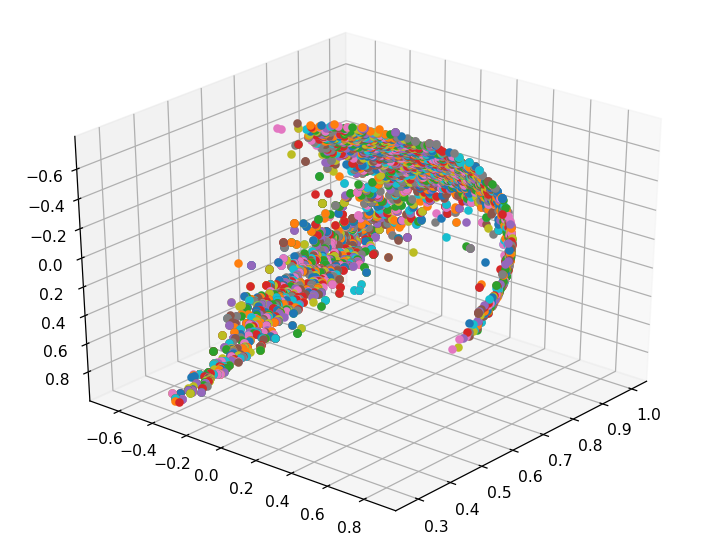

[[ 0.81264466 -0.36863813  0.45134752]
 [ 0.81264466 -0.36863813  0.45134752]
 [ 0.94444505 -0.28971702  0.15520177]
 ...
 [ 0.64830945  0.75271148  0.11454385]
 [ 0.82284872 -0.22194537 -0.52312544]
 [ 0.91920737 -0.28387678 -0.27289519]]


In [3]:
all_texts=[]
Y = []
start = time.process_time()
# os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//bbcsport")
os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//20NewsGroup-1")
directories = os.listdir()
label = 0
for directory in directories:
    path = os.path.join(os.getcwd(),directory)
    os.chdir(path)
    files = os.listdir()
    temp = []
    for file in files:
        with open(file,'r') as curr_file:
            all_texts.append(curr_file.read())
            Y.append(label)
    label = label + 1
    os.chdir('..')
os.chdir('..')
path = os.path.join(os.getcwd(),"GWO")
os.chdir(path)
tfidf = TfidfVectorizer(all_texts, stop_words='english')
vectors = tfidf.fit_transform(all_texts)
all_words = tfidf.get_feature_names()
vectors_dense = vectors.todense()
svd = TruncatedSVD(n_components=3)
vectors_dense_svd = svd.fit_transform(vectors_dense)
vectors_dense_svd = Normalizer().fit_transform(vectors_dense_svd)
end = time.process_time()
print("Time to pre-process"+str(end-start))
fig=plt.figure()
X = vectors_dense_svd
random.shuffle(X)
ax = Axes3D(fig)
print(X)
for j in range(len(X)):
    ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
    ax.view_init(330, 140)
plt.show()

In [4]:
max_iter = 100 #Maximum number of iterations
N = 12         #Population size (In the range 5 to 12)
K = 5         #Number of clusters

In [5]:
def population_initialization():
    '''
    Parameters:
    Output:
        N wolves of length K*D where D is the number of features
    Function:
        Takes K random datapoints from the dataset and appends them to create a chromosome
        This is repeated N times
    '''
    wolves_pack=[]
    for i in range(N):
        wolf=[]
        for j in range(K):
            wolf.append(X[random.randint(0,len(X)-1)])
        wolf=list(itertools.chain(*wolf))
        wolves_pack.append(wolf)
    return wolves_pack

In [6]:
#Function to decide cluster using Euclidean distance
def cosine_similarity(centers,datapoint):
    '''
    Parameters:
        centers: List of Cluster centers
        K : number of clusters
        datapoint : Datapoint
    Output:
        Cluster number alloted based on maximum cosine_similarity of the datapoint with the cluster centers
    '''
    #Cosine Similarity    
    t = np.asarray(datapoint)
    normt= np.linalg.norm(t)
    dot=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        normc = np.linalg.norm(temp_center)
        cos_sim_value=np.dot(t,temp_center)/(normt*normc)
        dot.append(cos_sim_value)
    
    return dot.index(max(dot))

In [7]:
def euclidean_dist_based_center_decision(centers,datapoint):
    t = np.asarray(datapoint)
    dist=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        dist.append(np.sqrt(np.sum(np.square(temp_center-t))))
    return dist.index(min(dist))

In [8]:
def fitness_function(wolf):
    '''
    Input : wolf -> A 1 x d(number of documents) vector containing the initial population
    Output: theta -> Fitness value of each wolf
    '''
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
        
    n_components=2
    svd = TruncatedSVD(n_components)
    U  = []
    for i in range(K):
        if(len(clusters[i])!=0):
            U.append(svd.fit_transform(clusters[i]))
    
    theta=0
    for i in range(n_components):
        for j in range(len(U)):
            for k in range(len(U)):
                if k!=j and (U[k].shape)[1]==(U[j].shape)[1]:
                    t1 = U[j][:,i]
                    t2 = U[k][:,i]
                    diff = abs(t2.shape[0]-t1.shape[0])
                    if t1.shape[0] < t2.shape[0]:
                        t1 = np.append(t1, np.zeros(diff))
                    elif t1.shape[0] > t2.shape[0]:
                        t2 = np.append(t2, np.zeros(diff))
                    temp = np.dot(t1,t2)/(np.linalg.norm(t1)*np.linalg.norm(t2))
                    theta=theta+math.acos(temp)
    
    centers=[]
    for i in range(K):
        temp=clusters[i]
        if len(temp)!=0:
            centers.append((np.sum(np.asarray(temp),axis=0)/len(temp)).tolist())
        else:
            temp_list=X[random.randint(0,len(X)-1)]
            centers.append(temp_list)
    
    wolf =[]
    for i in range(len(centers)):
        wolf.extend(centers[i])
    fitness_score = theta
    return fitness_score,wolf

In [9]:
def fitness_evaluation(wolves):
    '''
    Input: wolves -> A N x d dimension matrix containing wolves
    Output:fitness-> A N x 1 dimension vector containing fitness values of all wolves
    '''
    fitness = []
    new_wolves=[]
    for i in range(len(wolves)):
        fit,wolf = fitness_function(wolves[i])
        fitness.append(fit)
        new_wolves.append(wolf)
    return fitness,new_wolves

In [10]:
def find_beta(wolves, fitness):
    alpha = max(fitness)
    beta  = -1000
    for i in fitness:
        if beta<i and i!=alpha:
            beta = i
    return wolves[fitness.index(beta)]

In [11]:
def find_gamma(wolves,fitness, beta):
    alpha = max(fitness)
    gamma = -10000
    for i in fitness:
        if gamma<i and i!=alpha and i!=beta:
            gamma = i
    return wolves[fitness.index(gamma)]

In [12]:
def grey_wolf_optimization():
    gen_fitness = []
    start = time.process_time()
    wolves = population_initialization()
    fitness,wolves= fitness_evaluation(wolves)
    alpha  = wolves[fitness.index(max(fitness))] 
    beta   = find_beta(wolves, fitness)
    gamma  = find_gamma(wolves, fitness, fitness[wolves.index(beta)])
    
    a = 2
    
    C1 = 2*np.random.random(size = len(alpha))
    C2 = 2*np.random.random(size = len(beta))
    C3 = 2*np.random.random(size = len(gamma))
    
    A1 = 2*a*np.random.random(size = len(alpha)) - a 
    A2 = 2*a*np.random.random(size = len(beta)) - a
    A3 = 2*a*np.random.random(size = len(gamma)) - a
    
    t = 0
    gen_vs_fitness = []
    stop_gwo = False
    while t<max_iter and not stop_gwo:
        for i in wolves:
            if i!=alpha and i!=beta and i!=gamma:
                D_alpha = np.linalg.norm(np.dot(C1,alpha)-i)
                D_beta  = np.linalg.norm(np.dot(C2,beta)-i)
                D_gamma = np.linalg.norm(np.dot(C3,gamma)-i)

                X1 = alpha - A1*D_alpha
                X2 = beta - A2*D_beta
                X3 = gamma - A3*D_gamma

                i = (X1+X2+X3)/3
        #-----------------------------------------------------
        a = 2 - t*(2/max_iter)
        
        C1 = 2*np.random.random(size = len(alpha))
        C2 = 2*np.random.random(size = len(beta))
        C3 = 2*np.random.random(size = len(gamma))

        A1 = 2*a*np.random.random(size = len(alpha)) - a 
        A2 = 2*a*np.random.random(size = len(beta)) - a
        A3 = 2*a*np.random.random(size = len(gamma)) - a
        
        t = t + 1
        
        fitnes, wolves = fitness_evaluation(wolves)
        temp = []
        temp.append(str(t))
        temp.append(str(max(fitnes)))
        gen_fitness.append(temp)
        print("Generation "+ str(t) + ": "+str(max(fitnes)))
        if t>2 and abs(max(fitnes)-gen_vs_fitness[-1])<0.001 and abs(max(fitnes)-gen_vs_fitness[-2])<0.001:
            stop_gwo=True
            print("Stopping GWO because same results over past 2 generations")
        else:
            gen_vs_fitness.append(max(fitnes))
        alpha  = wolves[fitnes.index(max(fitnes))] 
        beta   = find_beta(wolves, fitnes)
        gamma  = find_gamma(wolves, fitnes, fitnes[wolves.index(beta)])
    
    end = time.process_time()
    print("Time taken: " + str(end-start))
    with open('GWO with K='+str(K)+'.csv','w+') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(gen_fitness)
    csvFile.close()
    return alpha

In [13]:
def intracluster_distances(wolf):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
   
    intracluster_d=[]
    for i in range(K):
        M=0
        temp=clusters[i]
        center=centers[i]
        for j in temp:
            M+=np.linalg.norm(np.asarray(j)-np.asarray(center))
        if len(temp)==0:
            M=0
        else:
            M=M/len(temp)
        intracluster_d.append(M)
    return intracluster_d

In [14]:
def davies_bouldin_index(wolf):
    intra_distance = intracluster_distances(wolf)
    
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    D = []
    for i in range(K):
        R = []
        for j in range(K):
            if i!=j:
                M = np.linalg.norm(np.asarray(centers[i])-np.asarray(centers[j]))
                r = (intra_distance[i]+intra_distance[j])/M
                R.append(r)
        D.append(max(R))
    return (1/K)*(np.sum(np.asarray(D)))

In [15]:
def silhoutette_index(wolf):
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])

    S = 0
    for i in range(K):
        for j in clusters[i]:
            a = 0
            b = 0
            t1 = np.asarray(j)
            for k in clusters[i]:
                t2 = np.asarray(k)
                a  = a + np.sqrt(np.sum(np.square(t1-t2)))
            for k in range(K):
                if i!=k:
                    for f in clusters[k]:
                        t2 = np.asarray(f)
                        b  = b + np.sqrt(np.sum(np.square(t1-t2)))
            s = (b-a)/max(a,b)
            S = S + s
    S = S/len(X)
    return S

In [16]:
def calinski_harabasz(wolf):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    #1. Calculating SSb:
    SSb = 0
    m = np.mean(X)
    for i in range(K):
        SSb += len(clusters[i])*np.square(np.linalg.norm(centers[i]-m))
    
    #2. Calculating SSw:
    SSw = 0
    for i in range(K):
        for j in clusters[i]:
            SSw += np.square(np.linalg.norm(j-centers[i]))
    
    ch_index = (SSb/SSw)*((len(X)-K)/(K-1))
    return ch_index

In [17]:
def dunn_index(wolf):
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    numerator = 10000000
    denominator=1
    for i in range(K):
        for j in range(K):
            if i!=j:
                numerator = min(numerator, np.sqrt(np.sum(np.square(np.asarray(centers[i])-np.asarray(centers[j])))))
    
    denominator = max(intracluster_distances(wolf))
    return numerator/denominator

In [18]:
def supervised_scores(wolf):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    Y_pred = []
    for i in range(len(X)):
        Y_pred.append(cosine_similarity(centers,X[i]))
#         Y_pred.append(euclidean_dist_based_center_decision(centers,X[i]))
    
    print(Y_pred)
    return f1_score(Y, Y_pred, average='micro'), accuracy_score(Y, Y_pred)    

In [19]:
def plot(wolf):
    centers=[]
    
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
   #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[cosine_similarity(centers,X[i])].append(X[i])
        clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    for i in range(K):
        print(len(clusters[i]))
    colors=['#ff3333','#000000','#ffd933','#dd6622','#84ff33','#33ffee','#3395ff','#d2a8fc','#abcdef']
    fig=plt.figure()
    ax = Axes3D(fig)
    for i in range(K):
        temp=clusters[i]
        for j in temp:
            ax.scatter(j[0], j[1], j[2], c=colors[i], marker='o')
            ax.view_init(330, 140)
    for i in range(K):
        temp=clusters[i]
        ax.scatter(centers[i][0],centers[i][1],centers[i][2],c='b',marker='X')

Generation 1: 15.116427578592893
Generation 2: 15.313429111471722
Generation 3: 15.062802592786054
Generation 4: 14.966022313363494
Generation 5: 14.870109188753688
Generation 6: 14.831312497612096
Generation 7: 14.823600479707777
Generation 8: 14.918725131340384
Generation 9: 14.835014441659778
Generation 10: 14.869111623877053
Generation 11: 14.878275922910026
Generation 12: 14.869111623877053
Generation 13: 14.878275922910028
Generation 14: 14.87827592291003
Generation 15: 14.833186956203813
Generation 16: 14.83318695620381
Generation 17: 14.83318695620381
Stopping GWO because same results over past 2 generations
Time taken: 70.28125
DB Index        :0.6231989714420101
Silhoutte Index :0.6925104298069267
Calinski-Harabasz Index :28268.559856799344
415
1909
2339


<IPython.core.display.Javascript object>


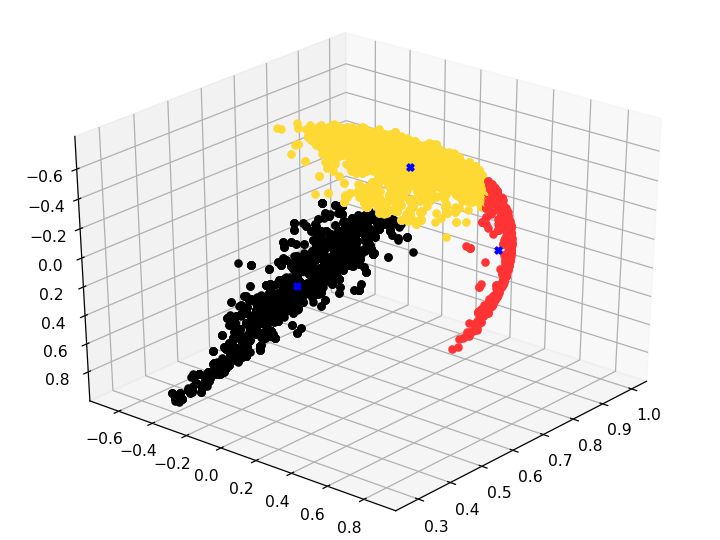

In [24]:
K = 3
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
# F1, Accuracy = supervised_scores(alpha)
# print("Accuracy        :"+str(Accuracy))
# print("F1 Score        :"+str(F1))
# print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(alpha)

Generation 1: 51.40012420123569
Generation 2: 50.19958506176336
Generation 3: 50.187731252314585
Generation 4: 49.7913688167185
Generation 5: 48.707865032486204
Generation 6: 48.50778101185435
Generation 7: 47.51126297194694
Generation 8: 47.01454194849641
Generation 9: 46.87367207656518
Generation 10: 46.8629421981543
Generation 11: 46.908943327058914
Generation 12: 47.02405461638504
Generation 13: 47.08247529592929
Generation 14: 46.922849498196705
Generation 15: 46.896571470626704
Generation 16: 47.0053459134546
Generation 17: 46.877416955337786
Generation 18: 47.005345913454605
Generation 19: 46.68703633924076
Generation 20: 46.55605425394089
Generation 21: 46.43302989698777
Generation 22: 46.2301089312368
Generation 23: 46.421960521980104
Generation 24: 46.2678728343633
Generation 25: 46.4219605219801
Generation 26: 46.2678728343633
Generation 27: 46.27570507636808
Generation 28: 46.19076538255564
Generation 29: 46.15323528545347
Generation 30: 46.15323528545347
Generation 31: 46.

<IPython.core.display.Javascript object>


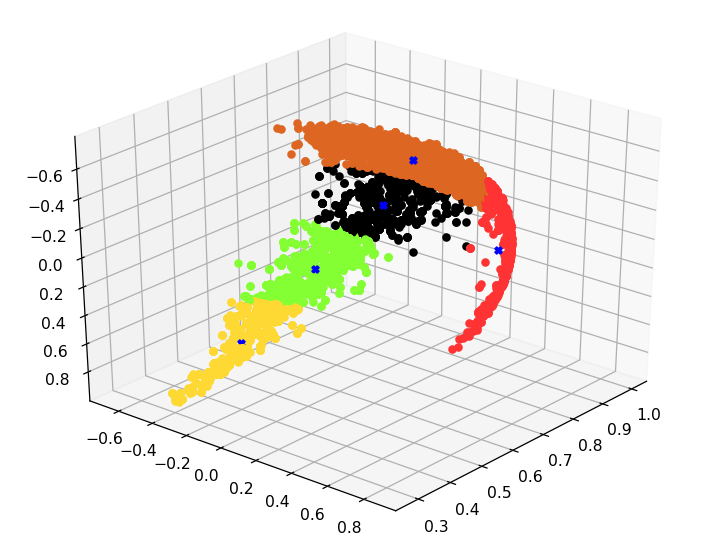

In [25]:
K = 5
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)

Generation 1: 98.04309838212839
Generation 2: 94.31810431037891
Generation 3: 93.92030204089637
Generation 4: 94.2713046677092
Generation 5: 94.36879251323036
Generation 6: 94.69150701737622
Generation 7: 94.3789166041748
Generation 8: 94.06049516137207
Generation 9: 93.65026046309154
Generation 10: 93.6738117472056
Generation 11: 93.4727077609312
Generation 12: 93.4134565065566
Generation 13: 93.66905081073917
Generation 14: 93.42134539744087
Generation 15: 92.69950792571123
Generation 16: 92.44880251249552
Generation 17: 92.47524261369588
Generation 18: 92.44296990239197
Generation 19: 92.32244767043868
Generation 20: 92.32244767043869
Generation 21: 92.32244767043869
Stopping GWO because same results over past 2 generations
Time taken: 137.328125
DB Index        :0.7564308613416931
Silhoutte Index :0.9498715335948873
Calinski-Harabasz Index :30700.483689395387
572
270
777
943
690
901
510


<IPython.core.display.Javascript object>


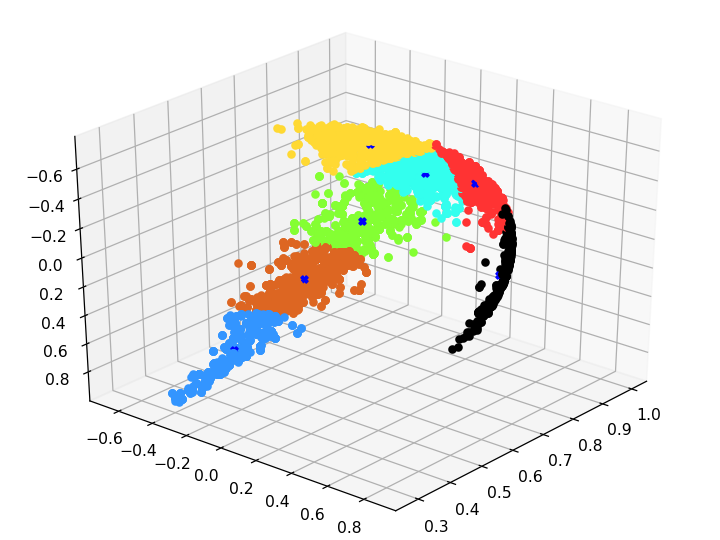

In [26]:
K = 7
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)

Generation 1: 175.33720168406646
Generation 2: 171.4924205874085
Generation 3: 170.1324790845081
Generation 4: 167.44679193611861
Generation 5: 167.49716836334812
Generation 6: 166.7780837437763
Generation 7: 166.34954480896982
Generation 8: 165.72571130485295
Generation 9: 165.72144510433586
Generation 10: 165.73174287152347
Generation 11: 164.430597236189
Generation 12: 164.18823460867992
Generation 13: 164.76998582938756
Generation 14: 164.3827492044397
Generation 15: 163.2519295666117
Generation 16: 163.12989248648265
Generation 17: 162.6883343806877
Generation 18: 162.77660849800355
Generation 19: 162.44756513091602
Generation 20: 162.74811546174095
Generation 21: 163.20309135520318
Generation 22: 163.39093428007766
Generation 23: 163.4041020018486
Generation 24: 163.29288274056603
Generation 25: 163.15729510397094
Generation 26: 163.47384354272606
Generation 27: 163.03272490555474
Generation 28: 163.1735722792076
Generation 29: 161.9973900349709
Generation 30: 162.47630973396798


<IPython.core.display.Javascript object>


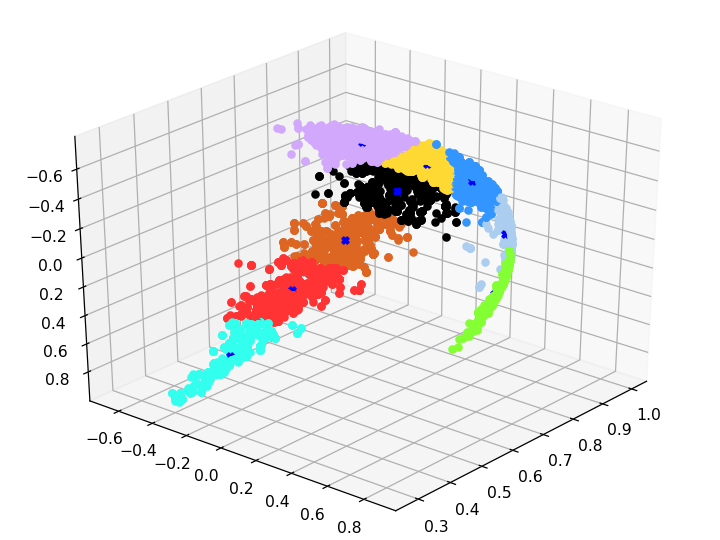

In [27]:
K = 9
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)